# URL Classification with Support Vector Machine (SVM)
This notebook implements URL classification (malicious URL detection) using SVM algorithm.
It includes comprehensive feature engineering, feature scaling, and model evaluation.

## 1. Import Libraries

In [35]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from urllib.parse import urlparse
from tld import get_tld
import os.path
from googlesearch import search
from joblib import Parallel, delayed

# ML libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix
import joblib
from wordcloud import WordCloud

# Cross validation
from sklearn.base import clone
from sklearn.model_selection import KFold

# Cuda core
# from thundersvm import SVC as ThunderSVC

# import warnings
# warnings.filterwarnings('ignore')

# CONFIG

SVM_MODEL = SVC(
    kernel='rbf',
    C=1.0,
    probability=True,
    random_state=42
)

APP_NAME='Malsy Gate'
DATA_PATH = "../artifacts/dataset_cleanup/data_cleaned.csv"
ATTATCH_PATH="../code/attatch"

MATRICS_PATH="../code/exports/matrics"
MODEL_PATH="../code/exports/models"
LABLE_PATH="../code/exports/labels"

## 2. Load Dataset

In [3]:
# Load the Dataset
df = pd.read_csv(DATA_PATH, nrows=500)

print(f"Dataset shape: {df.shape}")
print(f"\nDataset columns: {df.columns.tolist()}")
print(f"\nDataset head:")

df.head()

Dataset shape: (500, 3)

Dataset columns: ['url', 'type', 'isMalicious']

Dataset head:


,url,type,isMalicious
0,https://dr-carte.info/,NaN,False
1,https://www.dr-carte.info/,NaN,False
2,https://teal-usability-494962.framer.app/,NaN,False
3,http://iokjdh.pages.dev,NaN,False
4,https://iokjdh.pages.dev/,NaN,False


In [4]:
print("Data Info:")
df.info()

print("\nNull values:")
print(df.isnull().sum())

print("\nTarget distribution:")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   url          500 non-null    object 
 1   type         0 non-null      float64
 2   isMalicious  500 non-null    bool   
dtypes: bool(1), float64(1), object(1)
memory usage: 8.4+ KB

Null values:
url              0
type           500
isMalicious      0
dtype: int64

Target distribution:


In [5]:
print(df['isMalicious'].value_counts())

isMalicious
False    500
Name: count, dtype: int64


In [6]:
print(df['isMalicious'].value_counts(normalize=True))

isMalicious
False    1.0
Name: proportion, dtype: float64


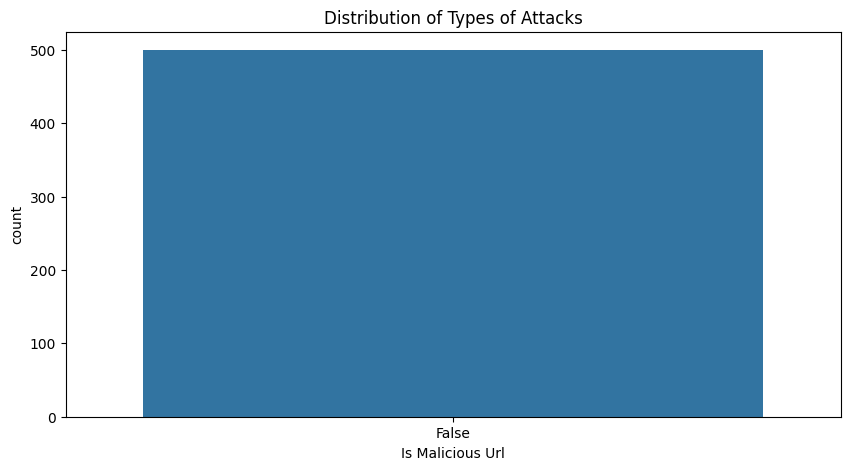

In [7]:
plt.figure(figsize= (10 , 5))
plt.title('Distribution of Types of Attacks')
sns.countplot(x = 'isMalicious', data = df)
# ax.bar_label(ax.containers[0])
plt.xlabel('Is Malicious Url')

plt.savefig(ATTATCH_PATH + '/type_of_accatck.png', bbox_inches='tight')

### WordCloud of url

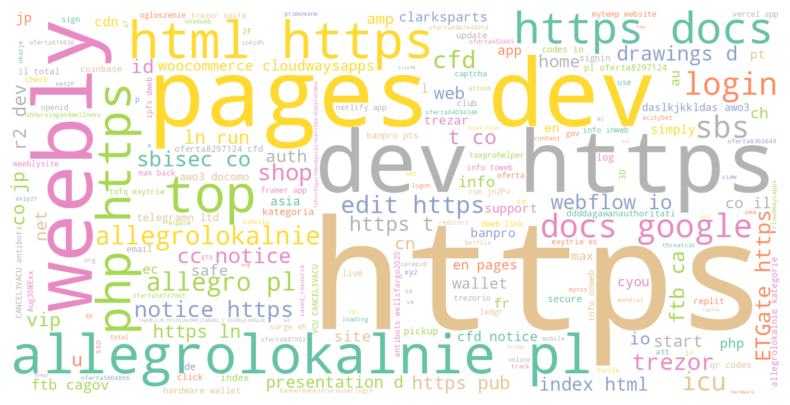

In [8]:
url = " ".join(i for i in df.url)
# print(url[0: 1000])

wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color="white",  
    colormap="Set2", 
    
).generate(url)

wordcloud.to_file(ATTATCH_PATH + '/url_wordcloud.png')

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3. Feature Extraction

### 3.1 IP Address Detection

In [9]:
# Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    
    if match:
        return 1
    else:
        return 0

df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))
print(df['use_of_ip'].value_counts())

use_of_ip
0    500
Name: count, dtype: int64


In [10]:
df[df['use_of_ip'] == 1]

,url,type,isMalicious,use_of_ip


Text(0.5, 1.0, 'Malsy Gate - Usage of Ip Address')

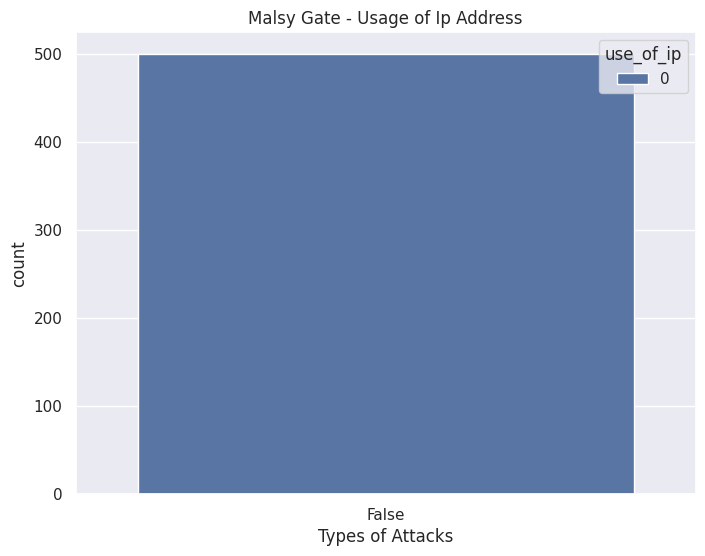

In [11]:
plt.figure(figsize = (8 , 6))
sns.set(style="darkgrid")
ax = sns.countplot(x="isMalicious", data=df, hue="use_of_ip")
plt.xlabel('Types of Attacks')
plt.title(APP_NAME + " - Usage of Ip Address")

**Shape data**

In [12]:
print(df.head())

                                         url  type  isMalicious  use_of_ip
0                     https://dr-carte.info/   NaN        False          0
1                 https://www.dr-carte.info/   NaN        False          0
2  https://teal-usability-494962.framer.app/   NaN        False          0
3                    http://iokjdh.pages.dev   NaN        False          0
4                  https://iokjdh.pages.dev/   NaN        False          0


In [13]:
arr = np.where(df['use_of_ip'] == 1)
arr[0].shape


(0,)

In [14]:
print(arr)

(array([], dtype=int64),)


### 3.2 Abnormal URL

In [15]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:      
        return 1
    else:
        return 0

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))
print(df['abnormal_url'].value_counts())

abnormal_url
1    500
Name: count, dtype: int64


Text(0.5, 1.0, 'Malsy Gate- Usage of Ip Address in domain name in with Diffrent types of attacks')

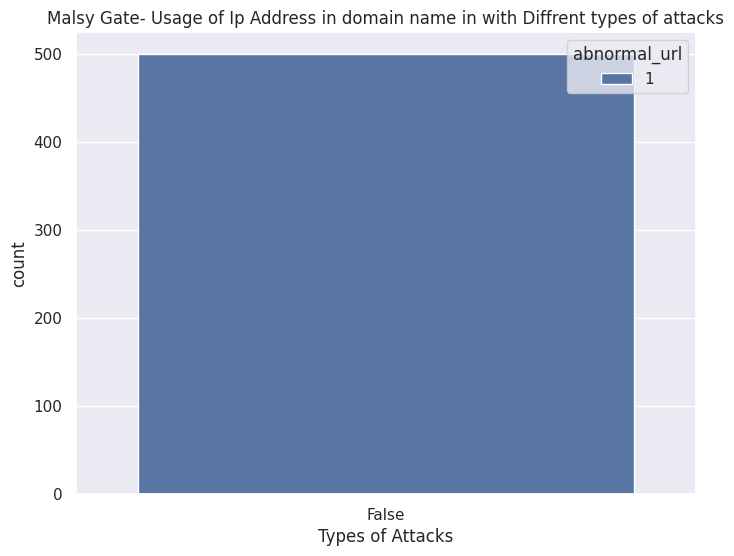

In [16]:
plt.figure(figsize = (8 , 6))
sns.set(style="darkgrid")
ax = sns.countplot(x="isMalicious", data=df, hue="abnormal_url")
plt.xlabel('Types of Attacks')
plt.title(APP_NAME + "- Usage of Ip Address in domain name in with Diffrent types of attacks")

**Shape data**

In [17]:
arr = df['abnormal_url'].value_counts()

print(arr)

# arr[0].shape
# arr

abnormal_url
1    500
Name: count, dtype: int64


### 3.3 Google Index

In [18]:
def google_index(url):
    
    site = search(url, 5)
    return 1 if site else 0

df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [19]:
print(df['url'][0])
for j in search(df['url'][0], num_results=10):
    print(j)

https://dr-carte.info/


In [20]:
df['google_index'].value_counts()

google_index
1    500
Name: count, dtype: int64

### 3.4 Count Features

In [21]:
# Count dot (.)
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count_.'] = df['url'].apply(lambda i: count_dot(i))

# Count www
def count_www(url):
    url.count('www')
    return url.count('www')

df['count_www'] = df['url'].apply(lambda i: count_www(i))

# Count @
def count_atrate(url):
    return url.count('@')

df['count_@'] = df['url'].apply(lambda i: count_atrate(i))

# Count directories
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

# Count embedded domains
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domain'] = df['url'].apply(lambda i: no_of_embed(i))



### 3.5 Suspicious Words Detection

In [22]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
    
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))

### 3.6 URL Shortening Service Detection

In [23]:
def shortening_service(url):
    match = re.search(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      r'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

### 3.7 Protocol Counts

In [24]:
# Count https
def count_https(url):
    return url.count('https')

df['count_https'] = df['url'].apply(lambda i: count_https(i))

# Count http
def count_http(url):
    return url.count('http')

df['count_http'] = df['url'].apply(lambda i: count_http(i))

### 3.8 Special Character Counts

In [25]:
# Count %
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i: count_per(i))

# Count ?
def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

# Count -
def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

# Count =
def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

### 3.9 Length Features

In [26]:
# URL length
def url_length(url):
    return len(str(url))

df['url_length'] = df['url'].apply(lambda i: url_length(i))

# Hostname length
def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

### 3.10 Domain Features

In [27]:
# First directory length
def fd_length(url):
    urlpath = urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

# TLD length
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld'] = df['url'].apply(lambda i: get_tld(i, fail_silently=True))
df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))
df = df.drop("tld", axis=1)

### 3.11 Character Counts

In [28]:
# Count digits
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

df['count_digits'] = df['url'].apply(lambda i: digit_count(i))

# Count letters
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df['count_letters'] = df['url'].apply(lambda i: letter_count(i))

In [29]:
print(df.head())

                                         url  type  isMalicious  use_of_ip  \
0                     https://dr-carte.info/   NaN        False          0   
1                 https://www.dr-carte.info/   NaN        False          0   
2  https://teal-usability-494962.framer.app/   NaN        False          0   
3                    http://iokjdh.pages.dev   NaN        False          0   
4                  https://iokjdh.pages.dev/   NaN        False          0   

   abnormal_url  google_index  count_.  count_www  count_@  count_dir  ...  \
0             1             1        1          0        0          1  ...   
1             1             1        2          1        0          1  ...   
2             1             1        2          0        0          1  ...   
3             1             1        2          0        0          0  ...   
4             1             1        2          0        0          1  ...   

   count%  count?  count-  count=  url_length  hostname_length

## 4. Label Encoding

In [30]:
# Label Encoding
label_encoder = LabelEncoder()
df['type_code'] = label_encoder.fit_transform(df['isMalicious'])

print("Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

print("\nTarget distribution after encoding:")
print(df['type_code'].value_counts())

Label mapping:
False: 0

Target distribution after encoding:
type_code
0    500
Name: count, dtype: int64


## 5. Feature and Target Creation

In [31]:
# Create feature matrix X and target vector Y
X = df[['use_of_ip','abnormal_url', 'count_.', 'count_www', 'count_@',
       'count_dir', 'count_embed_domain', 'short_url', 'count%', 'count?', 
       'count-', 'count=', 'url_length', 'count_https', 'count_http', 
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count_digits',
       'count_letters']]

Y = df['type_code']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {Y.shape}")
print(f"\nFeatures: {X.columns.tolist()}")

Feature matrix shape: (500, 21)
Target vector shape: (500,)

Features: ['use_of_ip', 'abnormal_url', 'count_.', 'count_www', 'count_@', 'count_dir', 'count_embed_domain', 'short_url', 'count%', 'count?', 'count-', 'count=', 'url_length', 'count_https', 'count_http', 'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count_digits', 'count_letters']


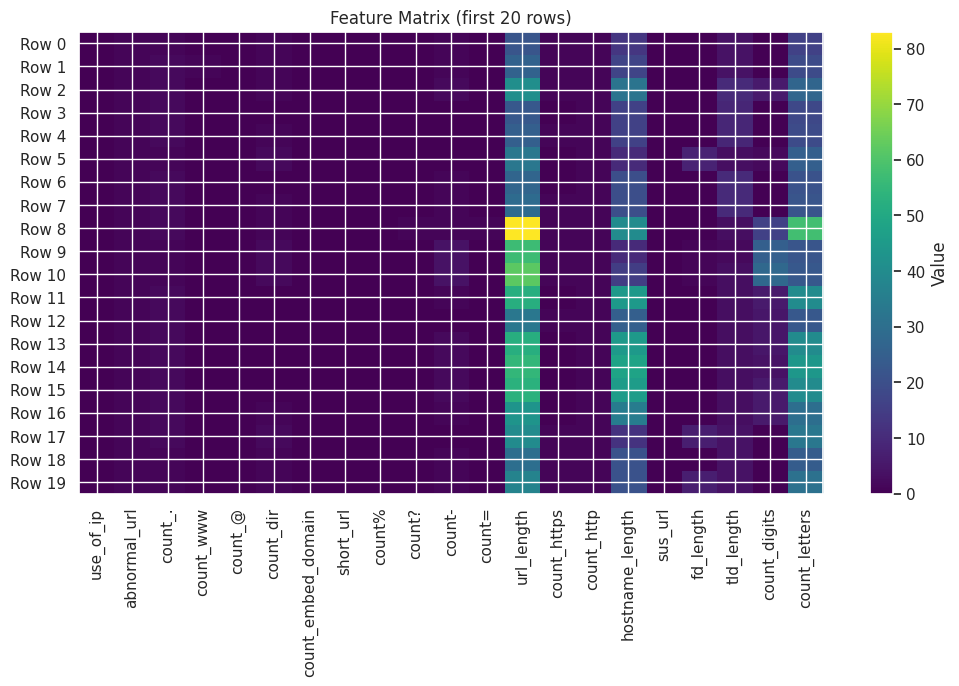

In [32]:
MAXIMUM_ROW=20

plt.figure(figsize=(12,6))
plt.imshow(X.head(MAXIMUM_ROW), aspect='auto', cmap="viridis")
plt.colorbar(label="Value")
plt.yticks(range(MAXIMUM_ROW), [f"Row {i}" for i in range(MAXIMUM_ROW)])
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.title("Feature Matrix (first " + str(MAXIMUM_ROW) +" rows)")
plt.show()

## 6. Cross validation

In [40]:
# Cross-Validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = SVM_MODEL   # unfitted SVM base model

def evaluate_fold(train_index, val_index, X, y, base_model):
    local_model = clone(base_model)

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    local_model.fit(X_train, y_train)
    y_pred = local_model.predict(X_val)

    return accuracy_score(y_val, y_pred)

accuracies = Parallel(n_jobs=-1)(
    delayed(evaluate_fold)(train_idx, val_idx, X, y, model)
    for train_idx, val_idx in kf.split(X)
)

print("Accuracies per fold:", accuracies)
print("Mean accuracy:", sum(accuracies) / len(accuracies))

NameError: name 'y' is not defined

## 7. Train-Test Split

In [ ]:
# Split the dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining target distribution:")
print(Y_train.value_counts())
print(f"\nTest target distribution:")
print(Y_test.value_counts())

Training set size: (603948, 21)
Test set size: (150988, 21)

Training target distribution:
type_code
0    417548
1    186400
Name: count, dtype: int64

Test target distribution:
type_code
0    104321
1     46667
Name: count, dtype: int64


## 8. Feature Scaling
SVM requires feature scaling for optimal performance.

In [ ]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data (using the same scaler fitted on training data)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

Feature scaling completed!
Scaled training set shape: (603948, 21)
Scaled test set shape: (150988, 21)


## 9. Training with SVM Model

In [ ]:
# svm_model = SVC(
#     kernel='rbf',
#     C=1.0,
#     probability=True,
#     random_state=42
# )

# svm_model = ThunderSVC(
#     kernel='rbf',
#     C=1.0,
#     # default gpu = 0: primary gpu, 1: secondary gpu
#     gpu_id=0,
#     probability=True,
#     random_state=42
# )

print("Training SVM model...")
print("This may take a few minutes...")
SVM_MODEL.fit(X_train_scaled, Y_train)
print("Training complete!")

Training SVM model...
This may take a few minutes...


## 10. Model Evaluation

In [ ]:
# Predictions
Y_pred_train = svm_model.predict(X_train_scaled)
Y_pred_test = svm_model.predict(X_test_scaled)

# Metrics
train_accuracy = accuracy_score(Y_train, Y_pred_train) * 100
test_accuracy = accuracy_score(Y_test, Y_pred_test) * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Detailed classification report
print("\n" + "="*50)
print("Classification Report (Test Set)")
print("="*50)
print(classification_report(Y_test, Y_pred_test, target_names=label_encoder.classes_))

Training Accuracy: 94.41%
Test Accuracy: 94.32%

Classification Report (Test Set)
              precision    recall  f1-score   support

      benign       0.96      0.99      0.97     85778
  defacement       0.93      0.97      0.95     19104
     malware       0.95      0.84      0.90      6521
    phishing       0.88      0.75      0.81     18836

    accuracy                           0.94    130239
   macro avg       0.93      0.89      0.91    130239
weighted avg       0.94      0.94      0.94    130239



## 11. Confusion Matrix

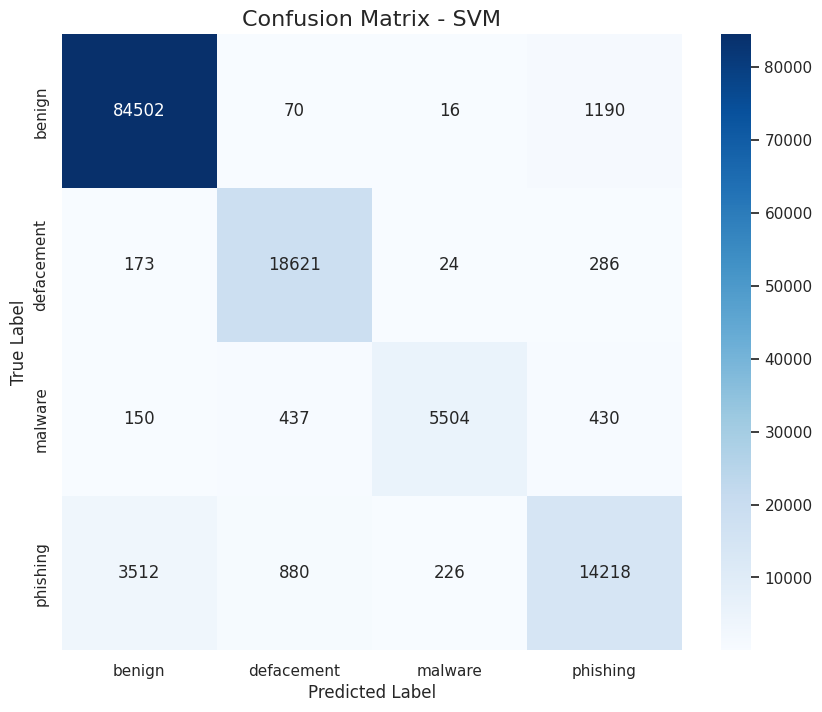

Confusion Matrix:
[[84502    70    16  1190]
 [  173 18621    24   286]
 [  150   437  5504   430]
 [ 3512   880   226 14218]]


In [ ]:
# Create confusion matrix
cm = confusion_matrix(Y_test, Y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - SVM', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(cm)

## 12. Model Export

In [ ]:
# Save the model
model_filename = 'svm_flag_model.pkl'
joblib.dump(svm_model, MODEL_PATH + "/" + model_filename)
print(f"Model saved as: {model_filename}")

# Save the scaler
scaler_filename = 'svm_flag_scaler.pkl'
joblib.dump(scaler, MODEL_PATH + "/" + scaler_filename)
print(f"Scaler saved as: {scaler_filename}")

# Save the label encoder
encoder_filename = 'label_encoder_svm_flag.pkl'
joblib.dump(label_encoder, LABLE_PATH + "/" + encoder_filename)
print(f"Label encoder saved as: {encoder_filename}")

# Save model performance metrics
metrics = {
    'model': 'SVM',
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'kernel': 'rbf',
    'C': 1.0,
    'random_state': 42
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(MATRICS_PATH + "/" + 'svm_model_metrics.csv', index=False)
print(f"Metrics saved to: svm_model_metrics.csv")

Model saved as: best_svm_model.pkl
Scaler saved as: svm_scaler.pkl
Label encoder saved as: label_encoder_svm.pkl
Metrics saved to: svm_model_metrics.csv


## 13. Summary

In [ ]:
print("="*60)
print("SVM MODEL SUMMARY")
print("="*60)
print(f"Algorithm: Support Vector Machine")
print(f"Kernel: RBF")
print(f"Regularization (C): 1.0")
print(f"Number of Features: {X.shape[1]}")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Test Samples: {X_test.shape[0]}")
print(f"\nPerformance:")
print(f"  - Training Accuracy: {train_accuracy:.2f}%")
print(f"  - Test Accuracy: {test_accuracy:.2f}%")
print(f"\nModel saved as: {model_filename}")
print(f"Scaler saved as: {scaler_filename}")
print("="*60)

SVM MODEL SUMMARY
Algorithm: Support Vector Machine
Kernel: RBF
Regularization (C): 1.0
Number of Features: 21
Training Samples: 520952
Test Samples: 130239

Performance:
  - Training Accuracy: 94.41%
  - Test Accuracy: 94.32%

Model saved as: best_svm_model.pkl
Scaler saved as: svm_scaler.pkl
